[![](https://bytebucket.org/davis68/resources/raw/f7c98d2b95e961fae257707e22a58fa1a2c36bec/logos/baseline_cse_wdmk.png?token=be4cc41d4b2afe594f5b1570a3c5aad96a65f0d6)](http://cse.illinois.edu/)

<a id='intro'></a>

# Debugging, Exceptions, and Bugs in Python (`pdb`)

It happens to the best of us.  Our code forged in the caffeine-fueled pits of night now brought forth to the day cracks and crumbles before our eyes.  But what can we do about it?

_Debugging_ is the process of identifying systematic errors in applications, whether from formal errors or modeling errors.  An example of a formal error is an out-of-bounds error on an array; an example of modeling error is mistyping the differential equation being solved.  Debugging either involves analyzing raw code, execution behavior, and output.

In [1]:
from __future__ import print_function, division

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

Consider the Zen of Python:

In [2]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


## Contents
- [Introduction](#intro)
- [Types of Bugs](#types)
    - [Exceptions and Errors](#excerr)
    - [Tracebacks](#traceback)
- [Handling bugs](#bughandle)
    - [Handling exceptions](#exchandle)
    - [Error Handling](#errhandle)
- [Linting](#linting)
- [Coding Standards](#codestd)
- [Python Debugger](#pdb)
    - [Debugging Step-by-Step](#stepbystep)
    - [PDB Example](#Bessel)
    - [Excercise](#ex1)
    - [pdb in IPython](#pdbipython)
- [Using a Context Manager for Elegant Expression](#with)
- [References](#refs)
- [Credits](#credits)

---
<a id='types'></a>
## Types of Bugs

A few working definitions for our discussion today:

- **Exceptions** — unusual behavior (although not necessarily unexpected behavior, particularly in Python)

- **Errors** — exceptions which cause the program to be unrunnable (cannot be handled at run time)

- **Tracebacks** — listing of function calls on the stack at the time the exception arises

- **Bugs** — errors and exceptions, but also miswritten, ambiguous, or incorrect code _which in fact runs_ but does not advertise its miscreancy



<a id='excerr'></a>
### Exceptions & Errors

Formally, an exception is an event raised to indicate that a function has failed.  Most of the time, this means that the function was passed bad data, or it encountered a situation it can't handle, or just reached a known invalid result, like division by zero.  (However, this may also be intentional—Python causes a container to raise a `StopIteration` exception to signal that there are no items left to iterate over, for instance in a `for` loop.)

Common exceptions include:
- `SyntaxError` — check missing colons or parentheses
- `NameError` — check for typos, function definitions
- `TypeError` — check variable types (coerce if necessary)
- `ValueError` — check function parameters
- `IOError` — check that files exist
- `IndexError` — don't reference nonexistent list elements
- `KeyError` — similar to an IndexError, but for dictionaries
- `ZeroDivisionError` — three guesses...
- `IndentationError` — check that spaces and tabs aren't mixed
- `Exception` — generic error category

### Exercise
- Write some snippets of code which throw the following exceptions:
    - `SyntaxError`
    - `NameError`
    - `TypeError`
    - `ValueError`
    - `IOError`
    - `IndexError`
    - `KeyError`
    - `ZeroDivisionError`

<a id='traceback'></a>
### Tracebacks

When something goes wrong in Python, the interpreter helpfully tries to show you where and why the exception occurred.  Although this can be intimidating to new users, the _traceback_ is quite useful in determining the offending bit of code.

Programs generally call functions on the _stack_:  that is, each time a function is called, the calling function is set aside and the new function becomes the active site for the program.  When this function completes, control is returned to the initial function.  When this extends across many function calls, we have a deep nested structure.

<TABLE cellspacing="0" cellpadding="0" rule=none>
  <TR>
    <TD>
    <code>
%% main.py
def do\_numerics():
    print(sin(5.0))

if \_\_name\_\_=="\_\_main\_\_":
    do_numerics()
    </code>
    </TD>
    <TD>
    <img width="320px" src="https://bytebucket.org/davis68/python/raw/5223ac27d7924df12b94b68c91f0790087df4809/lessons/img/fn-call-stack.png?token=d6730be3e51d9aa16e78a0ad7301cb006daacfdc" />
    </TD>
  </TR>
</TABLE>


This is what the traceback is showing us, indicating _where_ the code failed and tracing the _stack_, or nested function calls, to show you what the chain of calls was in case that helps you figure out why things went wrong.

/Users/rstein/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide
/Users/rstein/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: invalid value encountered in cos


ValueError: x and y must have same first dimension

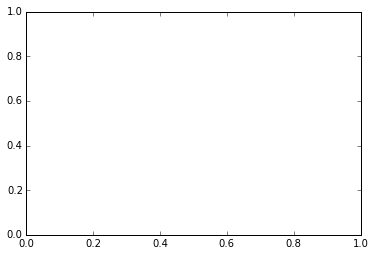

In [3]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0, 1, 10001)
y = np.cos(np.pi/x) * np.exp(-2*x)

plt.plot(x[0:-1:2], y)
plt.show()

Two things happened above:

- The first was a warning or two, marked in Jupyter by red highlighting.  These don't impact the successful completion of our code, but they can affect the quality of the results or have other externalities.

- Next, a misalignment of dimensions in the vectors we desire to plot leads to an irreconciliable difficulty in the code.  By my count in the current versions of NumPy and MatPlotLib, we are generating an error six layers deep in the function stack.
    
    In order to fix this problem, we need to align the vectors:  either sample `y` at the same rate as `x` or don't downsample `x`.

Tracebacks occasionally signal problems with your installation, rather than your code.  For instance, I recently had the following error arise:
    >>> from numpy import sin
    Traceback (most recent call last):
      File "<stdin>", line 1, in <module>
      File "/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/numpy/__init__.py", line 128, in <module>
        from version import git_revision as __git_revision__
    ImportError: No module named 'version'

It turns out that my distribution of Python was incorrectly using certain libraries:  the `$PYTHONPATH` environment variable was set up wrong.  (Incidentally, this is the sort of thing that has motivated people to counsel against using `$PYTHONPATH` at all.)  When fixed, the traceback disappeared and the `import` worked properly.

Let's try invoking a few more dramatic errors.  First, how about an infinite recursion?

In [4]:
f = lambda f:f(f)
f(f)

RuntimeError: maximum recursion depth exceeded

Of course, although the Python and IPython interpreters are extremely robust, there are limits.  The following, for instance, will crash the interpreter without even a traceback.

In [ ]:
# Try this in a Python interpreter.
import sys

sys.setrecursionlimit(1<<30)
f = lambda f:f(f)
f(f)

Tracebacks and exceptions are objects, and you can extract much more information if so inclined.  Try this sophisticated analysis of exceptions, using `sys.exc_info`:

In [2]:
import sys, os

try:
    raise NotImplementedError("No error")

except Exception as e:
    exc_type, exc_obj, exc_tb = sys.exc_info()
    fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
    print(exc_type.__name__, fname, exc_tb.tb_lineno)

NotImplementedError <ipython-input-2-68daa6beadce> 4


---
<a id='bughandle'></a>
## Handling bugs

<a id='exchandle'></a>
### Handling Exceptions (`try`/`except`/`else`/`finally`)

Now what we saw above were all in fact _errors_ in that they caused execution to halt.  What if we wanted to use them more intelligently—that is, to diagnose and handle problems before they crash our code?

This is what the `try`/`except`/`else`/`finally` workflow attempts to do.  Basically, we can write a snippet of code which is susceptible to a specific error which can be handled in a `try` block, and then deal with the aftermath in the `except` block.

In [3]:
try:
    x = 1 / 0
except ZeroDivisionError:
    print("Division by zero occurred.")

Division by zero occurred.


In [4]:
denom = 0
while True:
    try:
        # Read int from console.
        denom = input()
        
        # Use as denominator.
        i = 1 / float(denom)
    except:
        print("non-numeric value entered")
    else:
        print(i)
    finally:
        if denom == 'q': break

0
non-numeric value entered
n
non-numeric value entered
1
1.0
5
0.2
q
non-numeric value entered


`try`/`catch` error handling should encapsulate the fewest statements possible.  It can also reduce code readability, and so should probably be used only where things are likely to go wrong, in your judgment:  the file system, or some obtuse calculation.

Basically, `try` lets you execute an error-prone segment of code, while `except` lets you handle any or all of the errors that arise.  (It is better to handle less, as a general maxim, so that you don't mask other errors lurking in an operation.)  An optional `finally` clause will execute in any case.

In [6]:
filename = 'spring.data'
try:
    data = np.genfromtxt(filename)
except:
    print ('Unable to read file "%s".'%filename)

Unable to read file "spring.data".


In [ ]:
filename = 'spring.data'
try:
    data = np.genfromtxt(filename)
    print data
except IOError, err:
    print 'Unable to read file "%s"; %s.'%(filename,err)
    # why output err?  what else can go wrong?
finally:
    print 'Done with data loading code.'

<blockquote>_**The Principle of Least Astonishment**_:  The result of performing some operation should be obvious, consistent, and predictable, based upon the name of the operation and other clues.</blockquote>

### Raising Exceptions

Just as you can handle exceptions to make your code run properly, you can `raise` them as well.  Generic, specific, and user-specified exceptions are all available to you.

In [7]:
#raise( Exception, "This is my customised error message." ) #Python 2
raise Exception( "This is my customised error message." ) #Python 3

Exception: This is my customised error message.

### Should I Use Exceptions?

If we are going to intelligently use exceptions to control the execution of our program, what impact will this have?

- **Cons**
    - The use of exceptions for control structures (like `for` statements) is controversial.
    - In many languages, exception handling is expensive computationally and should be avoided.

- **Pros**
    - The function can adapt to circumstances without crashing.
    - Code can be written for the programmer, not for the machine.

The following code gives perspective on the case of relative efficiency in Python<sup>[(src)](http://www.jeffknupp.com/blog/2013/02/06/write-cleaner-python-use-exceptions/)</sup>:

In [8]:
SETUP = 'counter = 0'

LOOP_IF = """
counter += 1
"""

LOOP_EXCEPT = """
try:
    counter += 1
except:
    pass
"""

import timeit
if_time = timeit.Timer(LOOP_IF, setup=SETUP)
except_time = timeit.Timer(LOOP_EXCEPT, setup=SETUP)
print('using if statement: {}'.format(min(if_time.repeat(number=10 ** 7))))
print('using exception: {}'.format(min(except_time.repeat(number=10 ** 7))))

using if statement: 0.8740632349999942
using exception: 1.0919062199991458


So the use of exception-handling code is not that big of a deal—if `raise` makes your code easier to understand or operate, then please use it liberally.  Code that is easier to read and debug is code _less likely to have bugs_, since the emergent features can be well-characterized.

<a id='linting'></a>
### Linting

As I said before, you can debug by simply attempting to run your code. This, however, is very annoying. First off, the code will always stop at the first exception. This means that, if you have ten errors, you'll have to run the code ten times to find all of them. Now, imagine that this is long-running code. Imagine waiting five minutes for your code to run, only to discover it breaks because of a typo. Doesn't that sound exciting?
Linting is the process of statically analyzing the code in order to catch multiple errors simultaneously (rather than dealing with them one at a time in the debugger). There are several available; I'll illustrate the use of pyflakes.

<a id='codestd'></a>
### Coding Standards
In a written natural language, there are many ways to express the same idea.  To make the consumption of information easier, people define style guides to enforce particularly effective ways of writing.  This is even more true in coding; consistent style choices make scripts much easier to read.  Just like version control, standards become absolutely essential as projects become large ($n>1$, where $n$ is the number of coders).
 
Some programming languages have multiple competing standards, and it's easy to imagine how messy this can get.  You can find strong opinions on what constitutes a tab, for instance.  Luckily, Python doesn't have this issue.  The official standard, PEP8, is used everywhere.  Unless you plan on hiding all the code you write from the outside world, you should learn it.

To help out coders, there are tools to test for compliance.  The aptly named `pep8` library shows you where your code deviates from the PEP8 standard, and `autopep8` goes a step further by trying to fix all of your errors for you.  These are both run from the shell.  (They are not available in Canopy Basic, so you'll need to install them yourself or get the Academic license.)

<a id='pdb'></a>
## *P*ython *D*e*B*ugger (`pdb`)

Now that we've seen how errors and exceptions are raised and handled, let's handle some code interactively using [`pdb`](https://docs.python.org/3/library/pdb.html), an invaluable tool for finding subtle errors in numerical code, for instance.  (If you have used the [*G*NU *D*e*B*ugger](https://www.gnu.org/software/gdb/), `gdb`, before then you will see many similarities.)

Essentially, a common mode of use for `pdb` allows you to run your Python code normally until an error is reached in the interpreter.  At this point, your program crashes—you're probably used to this—but _all of the data remain available_, and you can manipulate them to figure out what went awry and why.  Another mode of interaction lets you pause program execution periodically so you can look "under the hood", figuring out exactly what is going on and whether the results align with expectations.

(This sounds a lot like the Python interpreter, and it is.  `pdb` just extends that functionality to standalone scripts as well.)

First, let's just run `pdb` in a conventional program, either in IPython (which works but can output some strange tracebacks occasionally) or in a conventional Python or IPython interpreter.  Another common method for using `pdb`—arguably more useful—is a GUI-based IDE such as [Spyder](https://pypi.python.org/pypi/spyder/2.3.1), which makes the active use of code breakpoints particularly tractable.

In [9]:
%%file pdb_vel.py
import numpy as np
import pdb

def y_fall(t, x0, v0):
    a = -9.8
    y = a*t**2 + v0*t + x0
    return y

v  = 2520 # m/s
x0 = 0    # m
t = np.arange(0,300,0.1) # s

pdb.set_trace()

print(y_fall(t, x0, v))

Writing pdb_vel.py


In [10]:
%run pdb_vel.py

> /Users/rstein/Dropbox/Python/python_sp16/lessons/pdb_vel.py(15)<module>()
-> print(y_fall(t, x0, v))
(Pdb) 5
5
(Pdb) k
*** NameError: name 'k' is not defined
(Pdb) v
2520
(Pdb) x0
0
(Pdb) t
array([  0.00000000e+00,   1.00000000e-01,   2.00000000e-01, ...,
         2.99700000e+02,   2.99800000e+02,   2.99900000e+02])
(Pdb) v
2520
(Pdb) print(v)
2520
(Pdb) t[0]
0.0
(Pdb) continue
[      0.        251.902     503.608 ..., -124992.882 -125328.392
 -125664.098]


When you execute `python pdb_vel.py`, you notice that a new prompt appears, `(Pdb)`.  At this prompt, you can type a series of commands.  Try, for instance, `print v` or `print t[0]`.  You can even directly manipulate variables:  `t[0] = -1`.  When you are ready to continue execution, enter `continue`, at which point the program will proceed directly (including the values of altered variables, if any).

#### Invocation

`pdb` can be invoked in several ways.  Generally speaking, you want it to either pop up _after_ an exception has been raised or run _continuously_ from a designated _breakpoint_.  The following chart illustrates a few ways you can get into the `pdb` interface.

![](https://bytebucket.org/davis68/python/raw/fd07c07b7b049d03024ca3a61fe143ebcc5d7ea6/lessons/img/pdb-invocation.png?token=a40dd88e3be4f02ca1aa94a26a4e21771e6faf3a)

#### Operation

This chart records the most commonly used `pdb` commands.  We'll do some hands-on exercises in a few minutes so you can get a feel for what they do, and which are the most useful in a given context.

![](https://bytebucket.org/davis68/python/raw/fd07c07b7b049d03024ca3a61fe143ebcc5d7ea6/lessons/img/pdb-usage.png?token=6ba619e45f3ce0cf833a1c964be24794ef6142ed)

Most of these need to be seen in context to appreciate them, but I'll point out up front the most frequently used:
    - `n[ext]`
    - `s[tep]`
    - `r[eturn]`
    - `p[rint]`

<a id='stepbystep'></a>
### Debugging a Code Step-by-Step

Let's take a look at an example script which takes a positive integer as an argument and outputs all positive integer factors of that integer.  Or, at least it _should_ do this.  Give it a shot below.

(This example is modified from one given in the [WinPDB](https://code.google.com/p/winpdb/wiki/DebuggingTutorial) documentation.)

In [11]:
%%file divisible.py
from __future__ import print_function
import sys

def is_divisible(a, b):
    """Determines if integer a is divisible by integer b."""
    
    remainder = a % b
    # if there's no remainder, then a is divisible by b
    if not remainder:
        return True
    else:
        return False

def find_divisors(integer):
    """Find all divisors of an integer and return them as a list."""

    divisors = []
    # we know that an integer divides itself
    divisors.append(integer)
    # we also know that the biggest divisor other than the integer itself
    # must be at most half the value of the integer (think about it)
    divisor = integer / 2

    while divisor >= 0:
        if is_divisible(integer, divisor):
            divisors.append(divisor)
        divisor =- 1

    return divisors

if __name__ == '__main__':
    # do some checking of the user's input
    try:
        if len(sys.argv) == 2:
            # the following statement will raise a ValueError for
            # non-integer arguments
            test_integer = int(sys.argv[1])
            # check to make sure the integer was positive
            if test_integer <= 0:
                raise ValueError("integer must be positive")
        elif len(sys.argv) == 1:
            # print the usage if there are no arguments and exit
            print(__doc__)
            sys.exit(0)
        else:
            # alert the user they did not provide the correct number of
            # arguments
            raise ValueError("too many arguments")
    # catch the errors raised if sys.argv[1] is not a positive integer
    except ValueError as e:
        # alert the user to provide a valid argument
        print("Error: please provide one positive integer as an argument.")
        sys.exit(2)

    divisors = find_divisors(test_integer)
    # print the results
    print("The divisors of %d are:" % test_integer)
    for divisor in divisors:
        print(divisor)

Writing divisible.py


In [12]:
!python divisible.py 100

The divisors of 100 are:
100
50.0


- Execute the code at the command prompt with `pdb` activated as follows:
        $ python -m pdb divisible.py 100

<a id='Bessel'></a>
### Another Example

Consider the following series statement for a Bessel function of the first kind,
$$J_{0}(x) = \sum_{m=0}^{\infty} \frac{(-1)^{m}}{m! (m+1)!} {\left(\frac{x}{2}\right)}^{2m} \text{.} $$

In [ ]:
%%file bessel.py
from scipy.misc import factorial2 as fact
from scipy.special import j0 # for testing error

import pdb
pdb.set_trace()

def term(m, x):
    return ((-1)**m)/(fact(m)*fact(m+1)*(0.5**x)*(2*m))

value = 0.5
max_term = 20
my_sum = 0.0
for i in range(0, max_term):
    my_sum += term(i, value)

print('series gives %f'%my_sum)
print('scipy gives %f'%j0(value))
print('error is %f'%(my_sum-j0(value)))

In [ ]:
!python bessel.py

<a id='pdbipython'></a>
### `pdb` in IPython

IPython has slightly enhanced support for [debugging](http://ipython.org/ipython-doc/stable/interactive/tutorial.html#debugging) as compared to the regular Python interpreter.  One convenient magic is `%debug`, which can be called immediately after failing code to analyze the traceback.  (This works poorly in the IPython Notebook, but is more tractable in the command-line interpreter.)

In [13]:
import string

greek = { 'a':u'α', 'b':u'β', 'g':u'γ', 'd':u'δ', 'e':u'ε', 'z':u'ζ' }

for letter in string.ascii_lowercase:
    print(greek[letter])

α
β


KeyError: 'c'

In [15]:
%debug

> <ipython-input-13-a9307ec7ade2>(6)<module>()
      4 
      5 for letter in string.ascii_lowercase:
----> 6     print(greek[letter])

ipdb> f
*** NameError: name 'f' is not defined
ipdb> continue


<a id='with'></a>
### Using a Context Manager for Elegant Expression (`with`)

Incidentally, one very useful practice is to allow a Python _context manager_ to deal with much of the boilerplate of setting up and _always_ taking down an object (even in the case of failure).  The `with` statement is used thus:

In [ ]:
sums = [sum(range(0,i+1)) for i in range(1,10)]

with open('sums.txt', 'w') as file_out:
    for value in sums:
        print(value, file=file_out)
print("Successfully wrote file.")
with open('sums.txt', 'r') as file_in:
    for line in file_in:
        print(line.strip(), end=',')
print("\nSuccessfully read file.")

Naturally it fails the same way, but it also closes the file without your explicit intervention.

In [ ]:
with open('nonexisting.txt', 'r') as file_in:
    for line in file_in:
        print(line.strip(), end=',')

Thus you still have exceptions raised as you would expect, but if a file operation—or anything else—fails, the object is automatically closed (deallocated, whatever is in `__exit__`) by the context manager arranged by `with`.  [(ref)](http://effbot.org/zone/python-with-statement.htm)

The following two snippets of code are thus equivalent [(src)](https://stackoverflow.com/questions/3642080/using-python-with-statement-with-try-except-block):

- Old way:
        try:
            f = open("file", "r")
            try:
                line = f.readline()
            finally:
                f.close()
        except IOError:
            # handle error

- New way:
        try:
            with open("file", "r") as f:
                line = f.readline()
        except IOError:
            # handle error

You can see that the first `open`s, reads, and `close`s the file; the second does the same, only much more elegantly and Pythonically.

<a id='ex1'></a>
### Exercise

Finite-difference models are used throughout engineering to obtain numerical solutions to differential equations.  This particular system models the heat equation

$$ \frac{1}{\alpha} \frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2}$$

given an initial condition of $u(x,t=0) = \sin\left(\pi x/L\right)$ and boundary conditions of $u(x=0,t) = 0$ and $u(x=L,t) = 0$.

To approximate a derivative, the most straightforward way is to take the formal definition

$$f'(x) = \frac{f(x+h)-f(x)}{h}$$

and use a small but nonzero step $h$ in your calculation.

Application of this principle to the heat equation leads to a statement of the form

$$ \frac{1}{\alpha} \frac{u^m_i - u^{m-1}_i}{\Delta t} = \frac{u^{m-1}_{i-1} - 2 u^{m-1}_{i} + u^{m-1}_{i+1}}{\Delta x^2} $$

or $u^m_i = \frac{\alpha \Delta t}{\Delta x^2}u^{m-1}_{i-1} + \left[1 - 2\left(\frac{\alpha \Delta t}{\Delta x^2}\right)\right]u^{m-1}_{i} + \frac{\alpha \Delta t}{\Delta x^2}u^{m-1}_{i+1}$.

This clearly yields a way to calculate subsequent time steps point-by-point from the previous time step's data.

- Debug the following finite-difference code using `pdb`.  Consider the following elements of the problem:
    - Are the sizes of `dt`, `dx`, etc., correct?
    - Are the ranges of the loops correct?
    - Are other definitions and equations correctly typed?

In [ ]:
%%file fd_he.py
import numpy as np

# Basic parameters
nt = 120
nx = 25
alpha = 0.1 
length = 1.0
tmax = 0.5

# Derived parameters:  mesh spacing and time step size
dx = length / nx
dt = tmax / (nt-1)

# Create arrays to save data in process.
x = np.linspace(0, length+1e-15, nx)
t = np.linspace(0, tmax+1e-15, nt)
u = np.zeros([nx, nt])

# Set initial and boundary conditions.
u[:, 0] = np.sin(np.pi*x/length)**2
#boundaries are implicitly set by this initial condition

# Loop through each time step.
r  = alpha * dt / (dx*dx)
s  = 1 - 2*r
for n in range(1, nt):
    for j in range(1, nx):
        u[n, j] = r*u[j-1, n-1] + s*u[j, n-1] + r*u[j+1, n-1]

# Output the results.
np.savetxt('fd_data.txt', u)

---
<a id='refs'></a>
## References

- Langtangen, Hans Petter.  _Python Scripting for Computational Science_, 3ed.  Berlin–Heidelberg:  Springer–Verlag, 2009.
- Lugo, Michael.  [On propagation of errors](http://gottwurfelt.com/2012/03/26/on-propagation-of-errors/).  26 March 2012.

---
<a id='credits'></a>
## Credits

Neal Davis and Lakshmi Rao developed these materials for [Computational Science and Engineering](http://cse.illinois.edu/) at the University of Illinois at Urbana–Champaign.  It incorporates some elements from [Software Carpentry](http://software-carpentry.org), contributed by Greg Wilson and others; and The Hacker Within, contributed by Katy Huff, Anthony Scopatz, Joshua R. Smith, and Sri Hari Krishna Narayanan.

<img src="http://i.creativecommons.org/l/by/3.0/88x31.png" align="left">
This content is available under a [Creative Commons Attribution 3.0 Unported License](https://creativecommons.org/licenses/by/3.0/).

[![](https://bytebucket.org/davis68/resources/raw/f7c98d2b95e961fae257707e22a58fa1a2c36bec/logos/baseline_cse_wdmk.png?token=be4cc41d4b2afe594f5b1570a3c5aad96a65f0d6)](http://cse.illinois.edu/)